# Библиотеки

In [45]:
import numpy as np
import pandas as pd
import math
 
import datetime
import random

import math 

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns 

from datetime import datetime, timedelta

import torch 
import torch.nn as nn

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

import scipy
from scipy import stats 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 ПРОВЕРКА ГИПОТЕЗ

## Функции

**Для входного потока**

In [2]:
def prepare_data(DATA, type):
  df = DATA[DATA['type'] == type]
  
  df = df.astype({"type": str, "change_timestamp": str})
  df['date'] = df['change_timestamp'].str[0:10]
  df['time'] = df['change_timestamp'].str[11:19]
  
  #перевод в формат даты
  df['date'] = pd.to_datetime(df['date'])

  #исключаем наблюдения после 10 июля 2019 г.
  # df = df[df['date'] < pd.to_datetime("2019-07-10")]

  # перевод в формат времени
  df['time'] = pd.to_datetime(df['time'],format= '%H:%M:%S' )
  
  # удаляем ненужные столбцы
  df.drop(columns=['type', 'change_timestamp'], inplace=True)
 
  return df

In [3]:
def count_num_of_appl_per_day(df, crop_date=""):
  num_of_appl = df.loc[:, ['date', 'time']].groupby('date').agg('count')
  num_of_appl.rename(columns={'time' : 'N'}, inplace=True)
  if crop_date:
    num_of_appl = num_of_appl.loc[:crop_date]
  return num_of_appl

In [4]:
def get_time_between_appls(df):
  df = df.sort_values(by=['date', 'time'])
  df['diff'] = (df['time']-df['time'].shift()).fillna(pd.Timedelta('0 days')).dt.total_seconds()
  df = df[df['diff'] >= 0]
  df.drop(columns=['time'], inplace=True)
  return df


**Для времени обслуживания**

In [5]:
def prepare_data_timeser(data, type):
  DATA = data[data['branch_id'] == 1]
  DATA = DATA[DATA['type'] == type]
  DATA.drop(columns=['id', 'equeue_ticket', 'branch_id', 'type'], inplace=True)
  DATA['date'] = DATA['serving_started'].str[0:10]
  DATA['serving_started'] = pd.to_datetime(DATA['serving_started'])
  DATA['serving_finished'] = pd.to_datetime(DATA['serving_finished'])
  DATA['time'] = (DATA['serving_finished'] - DATA['serving_started']).dt.total_seconds()
  DATA['date'] = pd.to_datetime(DATA['date'])
  DATA.drop(columns=['serving_started', 'serving_finished'], inplace=True)
  DATA.sort_values(by='date', inplace=True)
  return DATA

## Входной поток (время между последовательными заявками)

In [9]:
e_queue = pd.read_csv('drive/My Drive/Данные/equeue_ticket_order_act.csv', sep=';', usecols=[1,3,4,6], index_col=0)
e_queue = e_queue[e_queue['branch_id'] == 1] # оставляем только первый офис
e_queue.drop(columns=['branch_id'], inplace=True)

In [10]:
num_of_appl = e_queue.copy()
num_of_appl['date'] = num_of_appl['change_timestamp'].str[0:10]
num_of_appl['date'] = pd.to_datetime(num_of_appl['date'])
num_of_appl.sort_values(by=['date'], inplace=True)
num_of_appl = num_of_appl.loc[:, ['date', 'change_timestamp']].groupby('date').agg('count')
num_of_appl.rename(columns={'change_timestamp':'count'}, inplace=True)

In [13]:
delivery = prepare_data(e_queue, 'DELIVERY')
service = prepare_data(e_queue, 'SERVICE')
consultation = prepare_data(e_queue, 'CONSULTATION')

In [14]:
count_delivery = count_num_of_appl_per_day(delivery, '2020-03-28')
count_service = count_num_of_appl_per_day(service, '2020-03-28')
count_consultation = count_num_of_appl_per_day(consultation, '2020-03-28')

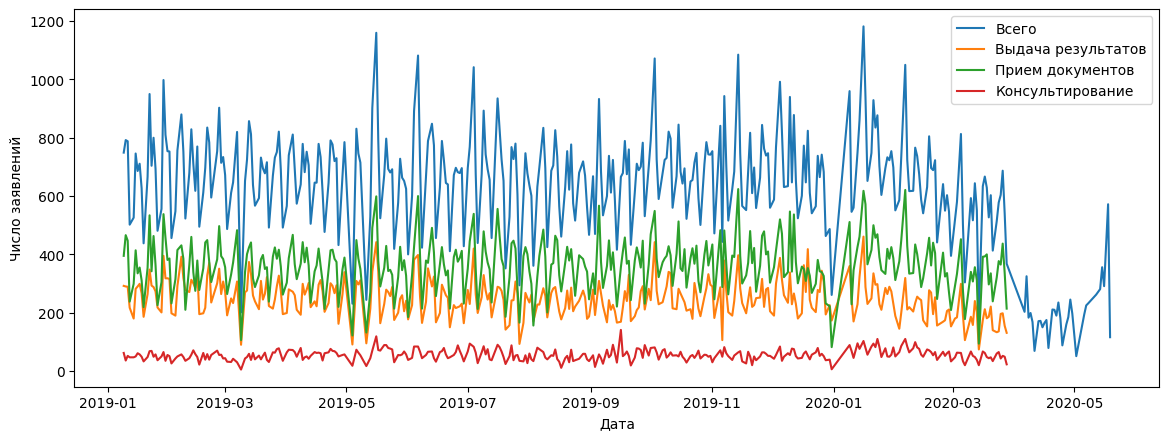

In [15]:
figure(figsize=(14, 5), dpi=100)
plt.plot(num_of_appl['count'], label='Всего')
plt.plot(count_delivery['N'], label='Выдача результатов')
plt.plot(count_service['N'], label='Прием документов')
plt.plot(count_consultation['N'], label='Консультирование')
plt.ylabel('Число заявлений')
plt.xlabel('Дата')
plt.legend()
None

In [16]:
time_diff_delivery = get_time_between_appls(delivery)
time_diff_service = get_time_between_appls(service)
time_diff_consultation = get_time_between_appls(consultation)

In [17]:
example_del = time_diff_delivery[time_diff_delivery['date'] == pd.to_datetime("2019-04-12")] #2019-04-12
example_ser = time_diff_service[time_diff_service['date'] == pd.to_datetime("2019-05-08")]
example_con = time_diff_consultation[time_diff_consultation['date'] == pd.to_datetime("2019-04-12")]

### Исследование закона распределения числа поступающих заявок

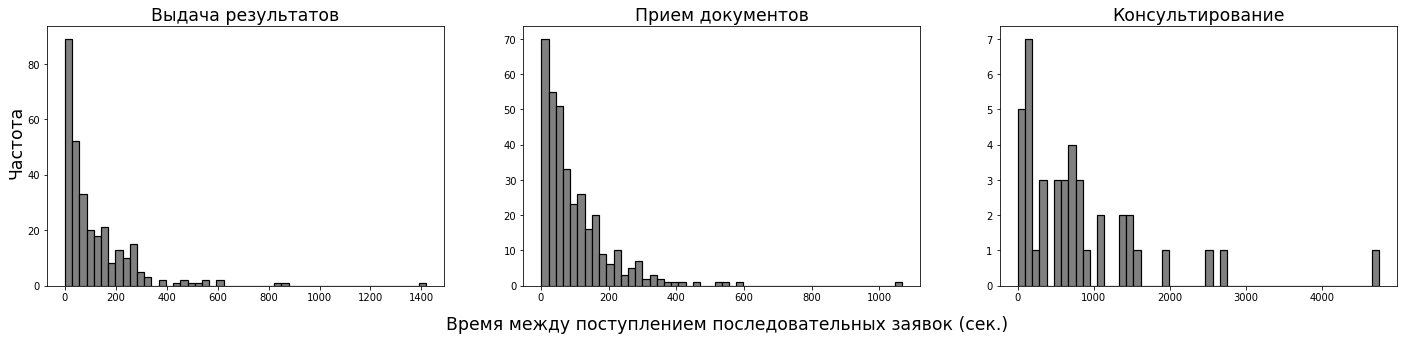

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))

plt.subplots_adjust(wspace=0.2, hspace=0.1, bottom = 0.1, top = 1, right=2)

axs[0].hist(example_del['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[0].set_title('Выдача результатов', fontsize='xx-large')

axs[1].hist(example_ser['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[1].set_title('Прием документов', fontsize='xx-large')

axs[2].hist(example_con['diff'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[2].set_title('Консультирование', fontsize='xx-large')

fig.text(1.07, -0.05, 'Время между поступлением последовательных заявок (сек.)', ha='center', fontsize='xx-large')
fig.text(0.07, 0.6, 'Частота', va='center', rotation='vertical', fontsize='xx-large')

None

In [21]:
example_del['diff'].describe()

count     301.000000
mean      117.013289
std       149.866896
min         1.000000
25%        26.000000
50%        66.000000
75%       155.000000
max      1417.000000
Name: diff, dtype: float64

In [22]:
(117/60)**-1

0.5128205128205129

In [23]:
example_ser['diff'].describe()

count     349.000000
mean       98.934097
std       109.237949
min         1.000000
25%        27.000000
50%        64.000000
75%       133.000000
max      1068.000000
Name: diff, dtype: float64

In [24]:
(98/60)**-1

0.6122448979591837

In [25]:
example_con['diff'].describe()

count      41.000000
mean      812.317073
std       909.300732
min         2.000000
25%       183.000000
50%       620.000000
75%      1053.000000
max      4747.000000
Name: diff, dtype: float64

In [26]:
(812/60)**-1

0.07389162561576355

In [27]:
ex_del = example_del['diff'][example_del['diff'] < 300] 
stats.anderson(ex_del, 'expon')

AndersonResult(statistic=1.2210000889348862, critical_values=array([0.92 , 1.076, 1.338, 1.603, 1.953]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [28]:
stats.anderson(example_ser['diff'], 'expon') 

AndersonResult(statistic=0.29506191355756073, critical_values=array([0.92 , 1.076, 1.339, 1.603, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [29]:
stats.anderson(example_con['diff'], 'expon') 

AndersonResult(statistic=0.3533888331356181, critical_values=array([0.909, 1.062, 1.322, 1.583, 1.929]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

## Время обслуживания

In [ ]:
tickets = pd.read_csv('drive/My Drive/Данные/equeue_ticket.csv', sep=';', index_col=False,
                      encoding = "cp1251", usecols=[0,2,3], error_bad_lines=False)

e_queue_tickets = pd.read_csv('drive/My Drive/Данные/equeue_ticket_order_act.csv',
                              usecols=[0,1,3,4], sep=';', index_col=0)

tickets_full = tickets.merge(right=e_queue_tickets, left_on='id', right_on='equeue_ticket')

del tickets, e_queue_tickets

In [ ]:
timeser_del = prepare_data_timeser(tickets_full, 'DELIVERY')
timeser_ser = prepare_data_timeser(tickets_full, 'SERVICE')
timeser_con = prepare_data_timeser(tickets_full, 'CONSULTATION')

### Исследование закона распределения времени обслуживания

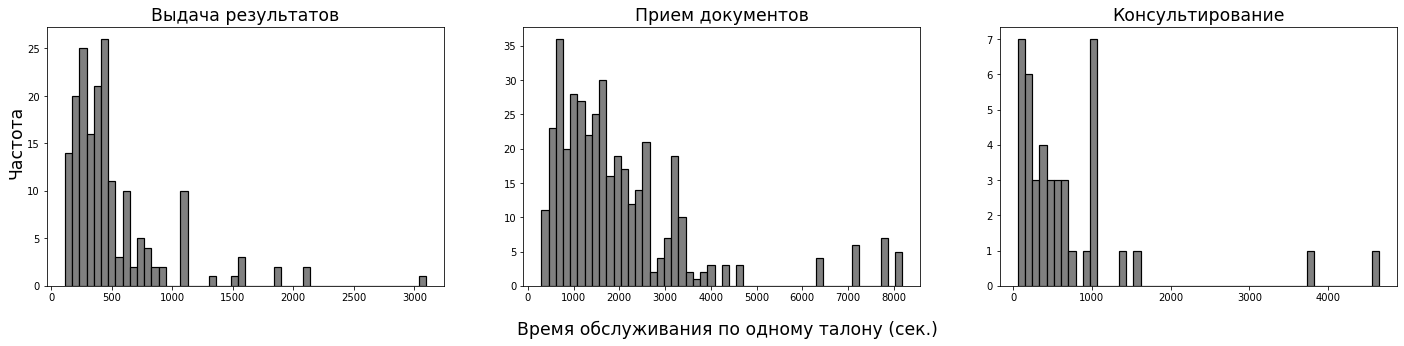

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))

plt.subplots_adjust(wspace=0.2, hspace=0.1, bottom = 0.1, top = 1, right=2)

axs[0].hist(example_time_del['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[0].set_title('Выдача результатов', fontsize='xx-large')

axs[1].hist(example_time_ser['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[1].set_title('Прием документов', fontsize='xx-large')

axs[2].hist(example_time_con['time'], bins=50, color='gray', edgecolor='black', linewidth=1.2)
axs[2].set_title('Консультирование', fontsize='xx-large')

fig.text(1.07, -0.07, 'Время обслуживания по одному талону (сек.)', ha='center', fontsize='xx-large')
fig.text(0.07, 0.6, 'Частота', va='center', rotation='vertical', fontsize='xx-large')

None

In [ ]:
example_time_del = timeser_del[timeser_del['date'] == pd.to_datetime('2020-03-18')]
example_time_ser = timeser_ser[timeser_ser['date'] == pd.to_datetime('2020-03-18')]
example_time_con = timeser_con[timeser_con['date'] == pd.to_datetime('2019-04-12')]

In [ ]:
example_time_del['time'].describe()

count     302.000000
mean      703.622993
std       550.975938
min        35.097000
25%       322.447750
50%       529.665000
75%       874.634500
max      3354.310000
Name: time, dtype: float64

In [ ]:
(703/60)**-1

0.08534850640113797

In [ ]:
example_time_ser['time'].describe()

count     350.000000
mean     1716.647674
std      1389.487986
min       111.404000
25%       799.117000
50%      1358.979500
75%      2123.377750
max      7974.123000
Name: time, dtype: float64

In [ ]:
(1716/60)**-1

0.03496503496503496

In [ ]:
example_time_con['time'].describe()

count      42.000000
mean      705.365167
std       884.256631
min        58.963000
25%       201.741500
50%       459.298500
75%       974.541250
max      4641.347000
Name: time, dtype: float64

In [ ]:
(705/60)**-1

0.0851063829787234

In [ ]:
ex_del = example_time_del['time'][example_time_del['time'] < 2500] 
stats.anderson(ex_del, 'expon')

AndersonResult(statistic=14.295089876524798, critical_values=array([0.919, 1.074, 1.337, 1.601, 1.95 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_del['time'], 'expon') 

AndersonResult(statistic=13.619457509938456, critical_values=array([0.919, 1.074, 1.337, 1.601, 1.951]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_ser['time'], 'expon') 

AndersonResult(statistic=22.46127406010845, critical_values=array([0.921, 1.076, 1.339, 1.604, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
ex_ser = example_time_ser['time'][example_time_ser['time'] < 7000] 
stats.anderson(ex_ser, 'expon') 

AndersonResult(statistic=18.515906316950577, critical_values=array([0.921, 1.076, 1.339, 1.604, 1.954]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.anderson(example_time_con['time'], 'expon')  # ++

AndersonResult(statistic=0.8272827434481229, critical_values=array([0.909, 1.063, 1.322, 1.583, 1.929]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

# 2 ПРОГНОЗИРОВАНИЕ ЧИСЛА ЗАЯВОК

## Функции

In [6]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [7]:
def predict(model, loss_fn, optim, epochs, data, test_data_size, train_window, fut_pred=7):
  all_data = data['N'].values

  train_data = all_data[:-test_data_size]
  test_data = all_data[-test_data_size:]

  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
  train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

  train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

  #обучение модели
  for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

  print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

  test_inputs = train_data_normalized[-train_window:].tolist()

  #прогнозирование
  model.eval()
  for i in range(test_data_size+fut_pred):
      seq = torch.FloatTensor(test_inputs[-train_window:])
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          test_inputs.append(model(seq).item())

  actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
  
  t = np.arange(datetime(2020,3,28)-timedelta(days=test_data_size),
                datetime(2020,3,28)+timedelta(days=fut_pred), timedelta(days=1)).astype(datetime)

  return actual_predictions, t


In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

## Прогнозирование

In [30]:
count_delivery = count_num_of_appl_per_day(delivery, '2020-03-28')
count_service = count_num_of_appl_per_day(service, '2020-03-28')
count_consultation = count_num_of_appl_per_day(consultation, '2020-03-28')

In [31]:
LSTM_model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)

In [32]:
preds, time = predict(LSTM_model, loss_function, optimizer, 100, count_delivery, 14, 14)

epoch:   1 loss: 0.00580520
epoch:  11 loss: 0.00044232
epoch:  21 loss: 0.04047599
epoch:  31 loss: 0.00141381
epoch:  41 loss: 0.00131634
epoch:  51 loss: 0.00316860
epoch:  61 loss: 0.04241654
epoch:  71 loss: 0.00116030
epoch:  81 loss: 0.00015754
epoch:  91 loss: 0.00015127
epoch:  99 loss: 0.0000059302


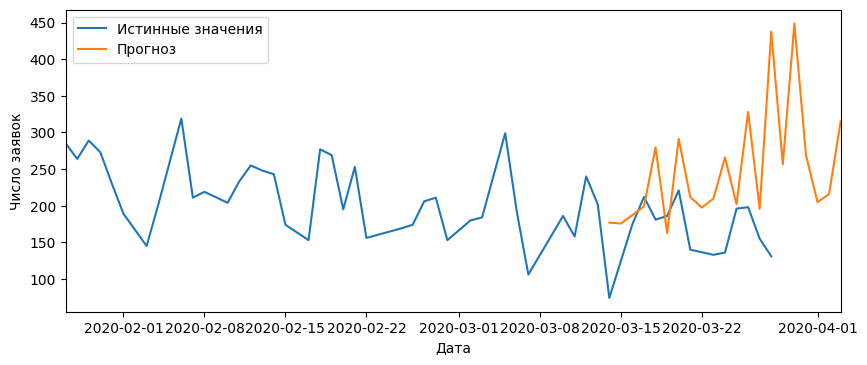

In [33]:
figure(figsize=(10, 4), dpi=100)
plt.xlabel("Дата")
plt.ylabel('Число заявок')
# plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(count_delivery['N'][-50:],label='Истинные значения')
plt.plot(time,preds, label='Прогноз')
plt.legend()
plt.show()

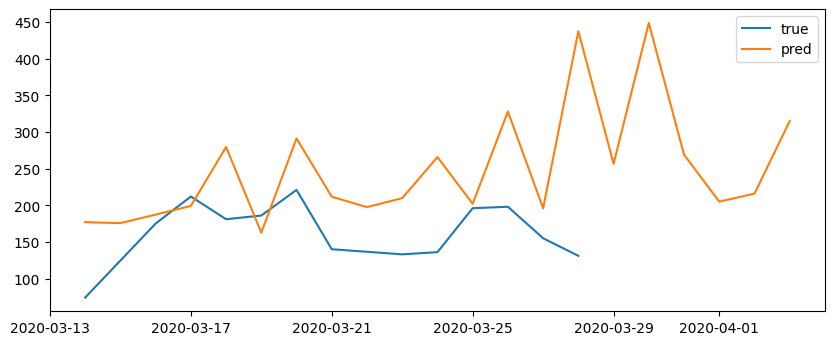

In [34]:
figure(figsize=(10, 4), dpi=100)
plt.plot(count_delivery['N'][-13:], label='true')
plt.plot(time,preds, label='pred')
plt.legend()
plt.show()

In [35]:
mean_squared_error(count_delivery['N'][-14:], preds[:-7])

5734.643632475026

In [36]:
mean_absolute_error(count_delivery['N'][-14:], preds[:-7]), max_error(count_delivery['N'][-14:], preds[:-7])

(61.86159617872909, 173.02840258181095)

## Keras

In [37]:
list_delivery = list(count_delivery['N']) #348дней
list_service = list(count_service['N'])
list_consultation = list(count_consultation['N'])

In [39]:
# функция для разбиения последовательности на обучающие наборы данных
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [40]:
def create_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw+1]
        inout_seq.append(train_seq)
    return inout_seq

In [41]:
create_sequences([1,2,3,4,5], 2)

[[1, 2, 3], [2, 3, 4], [3, 4, 5]]

In [42]:
def predict_keras(model, data, size_of_window, test_data_size, fut_pred):
  n_features = 1

  X, y = split_sequence(data, size_of_window) #разбиение на последовательность, подаваемую на вход, и на последующее значение
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  # Разбиение на тестовую и тренировочную выборки

  X_train, y_train = X[:-test_data_size], y[:-test_data_size]
  X_test, y_test = X[-test_data_size:], y[-test_data_size:]
  y_test = y_test.reshape(len(X_test), 1)

  del X, y

  # Обучение модели
  model.fit(X_train, y_train, verbose=0, epochs=150, validation_split=0.1)

  # Расчет метрик качества прогноза
  y_hat = model.predict(X_test)
  dif = y_test - y_hat

  RMSE = mean_squared_error(y_test, y_hat)**0.5
  MAE = mean_absolute_error(y_test, y_hat)
  ME = max_error(y_test, y_hat)
  MPE = sum(dif[dif>0])/len(dif[dif>0])
  MNE = sum(dif[dif<0])/len(dif[dif<0])

  #прогнозирование на будущий период (вне выборки)
  X_fut = create_sequences(y_hat, size_of_window)
  y_fut_hat = model.predict(X_fut) # прогноз на будущее время

  Metrics = dict({'Root Mean Square Error':RMSE, 'Mean Absolute Error':MAE, 'Max Error':ME, 'Mean Positive Error': MPE, 'Mean Negative Error': MNE})

  return y_hat, y_hat_fut, Metrics

In [48]:
train_window = 7
test_data_size = 14

In [46]:
lstm_keras = Sequential()
lstm_keras.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_window, 1)))
lstm_keras.add(Dropout(0.1))
lstm_keras.add(LSTM(75, activation='relu'))
lstm_keras.add(Dense(1))
lstm_keras.compile(optimizer='adam', loss='mse')

In [ ]:
preds, preds_fut, metrics = predict_keras(lstm_keras, list_delivery, train_window, test_data_size, 7)

In [50]:
model = lstm_keras
data = list_delivery
size_of_window = 7
test_data_size = 14
fut_pred = 10

In [51]:
n_features = 1

X, y = split_sequence(data, size_of_window) #разбиение на последовательность, подаваемую на вход, и на последующее значение
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Разбиение на тестовую и тренировочную выборки

X_train, y_train = X[:-test_data_size], y[:-test_data_size]
X_test, y_test = X[-test_data_size:], y[-test_data_size:]
y_test = y_test.reshape(len(X_test), 1)

del X, y

# Обучение модели
model.fit(X_train, y_train, verbose=0, epochs=150, validation_split=0.1)

# Расчет метрик качества прогноза
y_hat = model.predict(X_test)
dif = y_test - y_hat

RMSE = mean_squared_error(y_test, y_hat)**0.5
MAE = mean_absolute_error(y_test, y_hat)
ME = max_error(y_test, y_hat)
MPE = sum(dif[dif>0])/len(dif[dif>0])
MNE = sum(dif[dif<0])/len(dif[dif<0])


In [52]:
y_hat

array([[185.45798],
       [180.13065],
       [186.40631],
       [159.31299],
       [176.72101],
       [170.3193 ],
       [169.25491],
       [162.60272],
       [148.82831],
       [158.57504],
       [162.04019],
       [162.19826],
       [178.39954],
       [148.04738]], dtype=float32)

In [ ]:
data[-(size_of_window+i):]

In [53]:
y_hat = [item for sublist in y_hat.tolist() for item in sublist] #вытягиваем лист

In [54]:
#прогнозирование на будущий период (вне выборки)
y_fut_hat = []
data_full = data + y_hat

In [59]:
len(X_fut)

14

In [63]:
X_fut

array([202,  74, 175, 212, 181, 186, 221, 140, 133, 136, 196, 198, 155,
       131])

In [65]:
X_fut.shape

(14,)

In [73]:

for i in range(fut_pred):
  X_fut = np.array(data_full[-(test_data_size+i):(-2*test_data_size+i)])
  X_fut = X_fut.reshape((X_fut.shape[0], 1, n_features))
  y_fut_hat.append(model.predict(X_fut)) # прогноз на будущее время

ValueError: ignored

In [70]:
X_test.shape

(14, 14, 1)

In [71]:
X_fut.shape

(20, 1, 1)

In [68]:
len(y_fut_hat)

7

In [225]:
time = np.arange(datetime(2020,3,29)-timedelta(days=test_data_size),
                datetime(2020,3,29), timedelta(days=1)).astype(datetime)

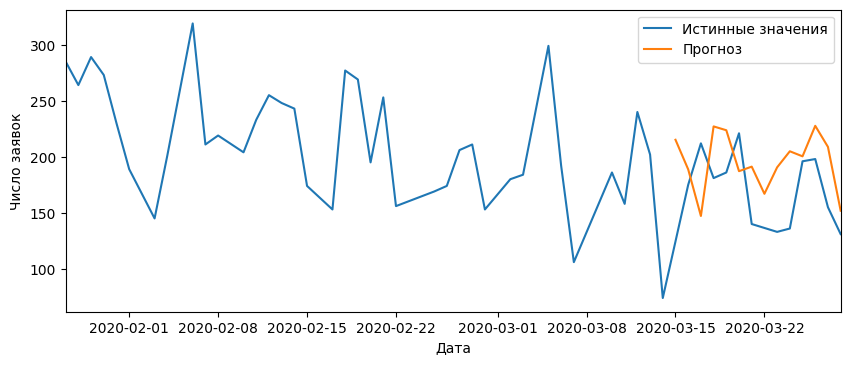

In [226]:
figure(figsize=(10, 4), dpi=100)
plt.xlabel("Дата")
plt.ylabel('Число заявок')
# plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(count_delivery['N'][-50:],label='Истинные значения')
plt.plot(time,preds, label='Прогноз')
plt.legend()
plt.show()